In [1]:
import hyperline
import requests
import pandas as pd
import time
import numpy as np
import json
import os

from tqdm import tqdm

In [2]:
def subgraph_pull(pool_id: str, block_number: int) -> dict:
    query = '''
    {
      pools(where: {id: "%s"}
                    block: {number: %i}
    ) {
        tick
        token0Price
        token1Price
      }
    }
    ''' % (pool_id, block_number)

    response = requests.post('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3', json={'query': query})
    res = response.json()

    if res.get('data') and res['data'].get('pools'):
        return res['data']['pools'][0]
    
    print(f"Query for pool_id {pool_id} block_number {str(block_number)} returned no results. \n{str(res)}")
    return None

In [3]:
def get_price_ts(pool_id="0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8",blocks=[]) -> pd.DataFrame:
    tmp_list = list()
    for i in tqdm(range(len(blocks))):
        block_number = blocks[i]
        cur_tick = subgraph_pull(pool_id, block_number)
        if cur_tick is not None:
            cur_tick['block_number'] = block_number
            tmp_list.append(cur_tick)
    
    df = pd.DataFrame.from_dict(tmp_list)

    # set column types
    df['tick'] = df.tick.astype('int')
    df['token0Price'] = df.token0Price.astype('float')
    df['token1Price'] = df.token1Price.astype('float')
    return df

In [4]:
POOL_ID = "0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8"
BLOCKS = list(range(12377369, 12537371, 1000))

df = get_price_ts(pool_id=POOL_ID, blocks=BLOCKS)

100%|██████████| 161/161 [00:47<00:00,  3.36it/s]


In [5]:
hyperline.sql.save_dataframe_to_my_table(df, table=f'table_tick_price_{POOL_ID}')

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='block_number'>

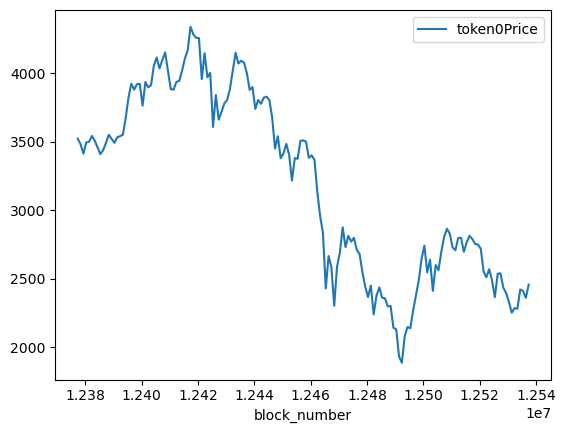

In [6]:
df['token0Price']=list(map(float, df['token0Price'].values))
df.plot('block_number','token0Price')

In [10]:
# See the file under "My Data > Files" on Hyperline website. Refresh MyData folder first.
# You can download to local machine or use the file within Hyperline referencing the same file 'location'